In [ ]:
!pip install pathway bokeh --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0
dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R² score: 0.9987202865855255


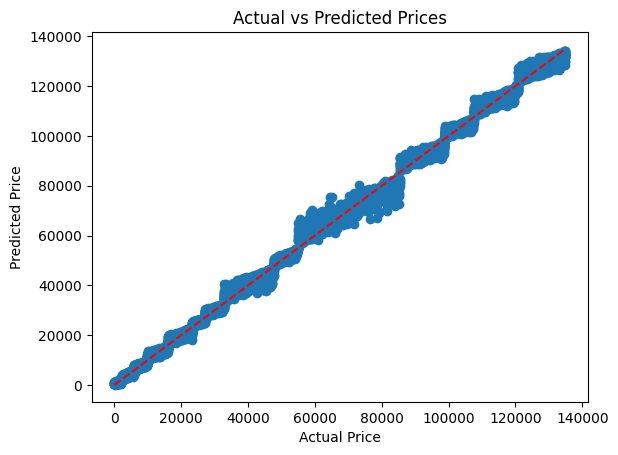

In [ ]:
import numpy as np
import pandas as pd
import pathway as pw
import bokeh.plotting
df=pd.read_csv('dataset.csv')

# Clean the data
print(df.isnull().sum())
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
# 1st BASE MODEL
df=pd.get_dummies(df,columns=['TrafficConditionNearby'],drop_first=True)
df['TrafficConditionNearby_high']=df['TrafficConditionNearby_high'].astype(int)
df.head()
base_price=10
base_alpha=5
capacity=577
df['alpha']=base_alpha + 0.1 * df['QueueLength'] + 1 * df.get('TrafficConditionNearby_high', 0)+ 0.1* df.get('IsSpecialDay', 1)
df['price'] = 0.0
df.loc[0, 'price'] = base_price
for i in range(1, len(df)):
    prev_price = df.loc[i - 1, 'price']
    occupancy = df.loc[i - 1, 'Occupancy']
    alpha = df.loc[i - 1, 'alpha']
    df.loc[i, 'price'] = prev_price + alpha * (occupancy / capacity)
df.head()
# outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

X=df_filtered[['Occupancy','Capacity','QueueLength','IsSpecialDay']]
Y=df_filtered[['price']]


from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X, Y)

score = model.score(X, Y)
print("R² score:", score)


import matplotlib.pyplot as plt

Y_pred = model.predict(X)

plt.scatter(Y, Y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--')
plt.show()

R² score: 0.9955974576891763


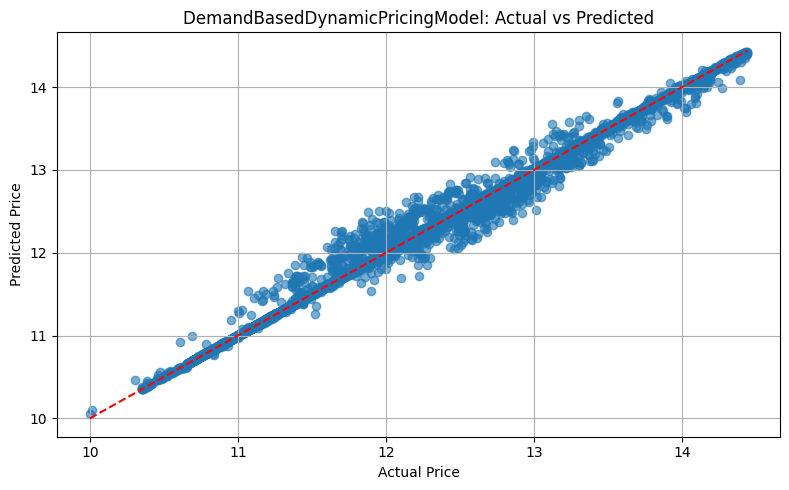

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# MODEL NAME: DemandBasedDynamicPricingModel

# Load the dataset
df = pd.read_csv('dataset.csv')

# Step 1: Clean the data
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Step 2: Encode categorical traffic condition
df = pd.get_dummies(df, columns=['TrafficConditionNearby'], drop_first=True)
df['TrafficConditionNearby_high'] = df['TrafficConditionNearby_high'].astype(int)

# Step 3: Add vehicle type weights
vehicle_type_weights = {
    'car': 1.0,
    'truck': 2.5,
    'bike': 0.5,
    'suv': 1.8,
    'van': 2.0
}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_weights).fillna(1.0)

# Step 4: Define constants for the demand formula
ALPHA = 1.0
BETA = 0.5
GAMMA = 1.2
DELTA = 0.7
EPSILON = 0.9
BASE_PRICE = 10
LAMBDA = 0.6

# Step 5: Calculate raw demand
df['DemandRaw'] = (
    ALPHA * (df['Occupancy'] / df['Capacity']) +
    BETA * df['QueueLength'] -
    GAMMA * df['TrafficConditionNearby_high'] +
    DELTA * df['IsSpecialDay'] +
    EPSILON * df['VehicleTypeWeight']
)

# Step 6: Normalize demand
scaler = MinMaxScaler()
df['DemandNorm'] = scaler.fit_transform(df[['DemandRaw']])

# Step 7: Calculate price based on normalized demand
df['Price'] = BASE_PRICE * (1 + LAMBDA * df['DemandNorm'])

# Step 8: Clamp prices to within [0.5x, 2x] of base
df['Price'] = df['Price'].clip(lower=0.5 * BASE_PRICE, upper=2 * BASE_PRICE)

# Step 9: Remove outliers
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Step 10: Define features and target
X = df_filtered[['Occupancy', 'Capacity', 'QueueLength', 'IsSpecialDay', 'VehicleTypeWeight']]
Y = df_filtered['Price']

# Step 11: Train model
model = RandomForestRegressor(random_state=42)
model.fit(X, Y)
score = model.score(X, Y)
print("R² score:", score)

# Step 12: Predictions and plot
Y_pred = model.predict(X)

plt.figure(figsize=(8, 5))
plt.scatter(Y, Y_pred, alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("DemandBasedDynamicPricingModel: Actual vs Predicted")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()
